#**Austin Waste Disposal**

##**Identity**

Ihsan Aulia Rahman

Full Time Data Science

HCK-Batch-001

##**Description**

###Problem Statement

The city of Austin has a load of waste being disposed everyday. As a data scientist, we are challenged by this assigment to pull some insight out of it.

###Objective

The goals of this assignment are:

1. Load the data from Google Cloud BigQuery
2. Clean up the data 
3. See the central tendencies of the data
4. Check the data's spread
5. Use confidence interval and hypotesting on the data



#**A. Libraries**

Here we import the necessary function libraries for the job.

In [2]:
import numpy as np
from numpy.linalg import inv, det, eig
from numpy import diag

import sympy as sy
from sympy.tensor.array import derive_by_array

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import *

import scipy
import scipy.stats as stats

def plot_vector2d(vector2d, origin=[0, 0], **options):
    return plt.arrow(origin[0], origin[1], vector2d[0], vector2d[1],
              head_width=0.2, head_length=0.3, length_includes_head=True,
              **options)

#**B. Loading**

##**B.1. Query from Google Cloud**

The data we are going to use is the Austin Waste and Diversion from Google Cloud BigQuery titled `bigquery-public-data.austin_waste.waste_and_diversion`.

We are told to limit our query on certain columns and time period. To extract the relevant data, we need to input a query in the Cloud console in SQL language.

In [5]:
"""
select report_date,load_time, load_type, load_weight, dropoff_site
from `bigquery-public-data.austin_waste.waste_and_diversion`
where report_date >= "2021-01-01" and report_date <= '2021-07-09';
"""

'\nselect report_date,load_time, load_type, load_weight, dropoff_site\nfrom `bigquery-public-data.austin_waste.waste_and_diversion`\nwhere report_date >= "2021-01-01" and report_date <= \'2021-07-09\';\n'

The lines in the code are commented out because they are in SQL language which cannot be run on this Python notebook.

The queried data is then saved as .csv file.

##**B.2. Read .csv file as dataframe variable**

To read the .cdv file in Python notebook, we use the Pandas function to read it and assign into a variable called `df` for convenience.

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/IARahman/Austin-Waste-and-Diversion/main/h8dsft_P0GC2_Ihsan_aulia_Rahman.csv')

#**C. Cleaning**

##**C.1. Dropping null rows and optimizing data types**

Before we begin, let's remove unnecessary parts from our data. That is, rows that has `0` or `NaN` as a value. 

Let's also optimize the data type of timestamp columns just in case we are going to do time related functions.

In [7]:
df.dropna(axis=0, inplace = True)
df.drop(df[df["load_weight"] == 0].index, inplace = True)
df['report_date'] = pd.to_datetime(df["report_date"])
df['load_time'] = pd.to_datetime(df["load_time"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25106 entries, 0 to 26156
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   report_date   25106 non-null  datetime64[ns]     
 1   load_time     25106 non-null  datetime64[ns, UTC]
 2   load_type     25106 non-null  object             
 3   load_weight   25106 non-null  float64            
 4   dropoff_site  25106 non-null  object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), object(2)
memory usage: 1.1+ MB


##**C.2. Initial Exploration**

With this cleaned up data, we can proceed to explore our data a little.

###C.1.1. Checking the shape, head and tail of dataframe

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25106 entries, 0 to 26156
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   report_date   25106 non-null  datetime64[ns]     
 1   load_time     25106 non-null  datetime64[ns, UTC]
 2   load_type     25106 non-null  object             
 3   load_weight   25106 non-null  float64            
 4   dropoff_site  25106 non-null  object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), object(2)
memory usage: 1.1+ MB


The data has 25106 rows and 5 columns.

In [9]:
df.head()

,report_date,load_time,load_type,load_weight,dropoff_site
0,2021-07-08,2021-07-08 12:00:00+00:00,TIRES,2260.0,MRF
1,2021-07-08,2021-07-08 11:00:00+00:00,TIRES,1260.0,MRF
2,2021-07-08,2021-07-08 03:00:00+00:00,TIRES,800.0,MRF
3,2021-05-01,2021-05-01 12:29:00+00:00,TIRES,760.0,MRF
4,2021-07-03,2021-07-03 12:09:00+00:00,TIRES,1400.0,MRF


In [10]:
df.tail()

,report_date,load_time,load_type,load_weight,dropoff_site
26152,2021-03-01,2021-03-01 11:26:00+00:00,ORGANICS,12100.0,ORGANICS BY GOSH
26153,2021-03-01,2021-03-01 04:27:00+00:00,ORGANICS,10900.0,ORGANICS BY GOSH
26154,2021-03-01,2021-03-01 05:55:00+00:00,ORGANICS,21800.0,ORGANICS BY GOSH
26155,2021-03-01,2021-03-02 01:10:00+00:00,ORGANICS,5640.0,ORGANICS BY GOSH
26156,2021-03-01,2021-03-01 10:22:00+00:00,RECYCLED METAL,360.0,AUSTIN IRON AND METAL


It looks like `report_date` and `load_time` columns are not synchronized. We'll continue referring to `report_date` from here on.

###C.1.2. Checking range and unique values in columns

In [11]:
df['report_date'].agg(("min", "max"))

min   2021-01-02
max   2021-07-09
Name: report_date, dtype: datetime64[ns]

In [12]:
df['load_time'].agg(("min", "max"))

min   2020-06-27 01:00:00+00:00
max   2021-07-11 07:07:45+00:00
Name: load_time, dtype: datetime64[ns, UTC]

We already know that `report_date` and `load_time` columns are not synchronized.

In [13]:
df['load_type'].nunique()

14

In [14]:
df['load_type'].value_counts()

GARBAGE COLLECTIONS          8241
RECYCLING - SINGLE STREAM    6760
ORGANICS                     5749
BULK                         1594
BRUSH                        1514
SWEEPING                      360
MIXED LITTER                  326
TIRES                         175
DEAD ANIMAL                   150
YARD TRIMMING                 137
RECYCLED METAL                 57
LITTER                         41
CONTAMINATED RECYCLING          1
CONTAMINATED ORGANICS           1
Name: load_type, dtype: int64

There are 14 types of waste processed in Austin

In [15]:
df['load_weight'].agg(("min", "max"))

min         0.1164
max    245540.0000
Name: load_weight, dtype: float64

There is a load that only weights 0.1 lbs. It is most likely an outlier

In [16]:
df['dropoff_site'].nunique()

14

There are 14 dumping sites serving Austin.

#**D. Central Tendency of Each Sites**

Let's take a look of the data on each sites

##**D.1. Site descriptions**

In [17]:
df['dropoff_site'].value_counts()

TDS LANDFILL             10688
ORGANICS BY GOSH          5741
BALCONES RECYCLING        3837
TDS - MRF                 2948
HORNSBY BEND              1652
MRF                        168
AUSTIN IRON AND METAL       50
ON ROUTE HIGH DUMP           7
GREAT NORTHERN               6
PARK BEND                    4
AUSTIN WOOD RECYCLING        2
BALCONES WOODS               1
STEINER LANDFILL             1
WESTFIELD                    1
Name: dropoff_site, dtype: int64

In [18]:
np.set_printoptions(suppress=True)
df.groupby('dropoff_site').agg(Average=('load_weight',np.mean),
                               Median =('load_weight',np.median),
                               Mode   =('load_weight',stats.mode),
                               Total  =('load_weight',np.sum))

,Average,Median,Mode,Total
dropoff_site,,,,
AUSTIN IRON AND METAL,451.200000,400.0,"([260.0], [3])",2.256000e+04
AUSTIN WOOD RECYCLING,4050.000000,4050.0,"([2340.0], [1])",8.100000e+03
BALCONES RECYCLING,9464.652072,9840.0,"([11880.0], [22])",3.631587e+07
BALCONES WOODS,8460.000000,8460.0,"([8460.0], [1])",8.460000e+03
GREAT NORTHERN,19153.333333,21110.0,"([8700.0], [1])",1.149200e+05
HORNSBY BEND,6628.644068,6390.0,"([5500.0], [47])",1.095052e+07
MRF,1799.982143,1360.0,"([960.0], [5])",3.023970e+05
ON ROUTE HIGH DUMP,12525.714286,14940.0,"([4060.0], [1])",8.768000e+04
ORGANICS BY GOSH,11818.482146,11920.0,"([14580.0], [17])",6.784991e+07


##**D.2. Load types from selected sites**

In [19]:
df.loc[df['dropoff_site']=='TDS LANDFILL']['load_type'].value_counts()

GARBAGE COLLECTIONS          8203
BULK                         1590
SWEEPING                      358
MIXED LITTER                  326
DEAD ANIMAL                   131
LITTER                         40
ORGANICS                       22
TIRES                          10
RECYCLING - SINGLE STREAM       3
BRUSH                           2
CONTAMINATED RECYCLING          1
CONTAMINATED ORGANICS           1
RECYCLED METAL                  1
Name: load_type, dtype: int64

In [20]:
df.loc[df['dropoff_site']=='ORGANICS BY GOSH']['load_type'].value_counts()

ORGANICS               5714
DEAD ANIMAL              19
RECYCLED METAL            5
SWEEPING                  2
GARBAGE COLLECTIONS       1
Name: load_type, dtype: int64

In [21]:
df.loc[df['dropoff_site']=='TDS - MRF']['load_type'].value_counts()

RECYCLING - SINGLE STREAM    2917
GARBAGE COLLECTIONS            28
BULK                            2
LITTER                          1
Name: load_type, dtype: int64

##**D.3. Findings**

From the table produced from the data, we can see that Great Northern had the highest average load weight at 21 thousand lbs at every load. However, that site only receive loads intermittently and rank among the lowest total load intake. 

Texas Disposal System Landfill had only more than 15 thousand lbs per load on average but took more than 10 thousand loads resulting in total 162 million lbs of waste processed there. TDSL processed the highest amount of waste between other sites by a long margin. 

Moreover, unlike other sites that specialize on specific type of waste, TDSL processes more general load types collected from the city.

Those would be our background to examine this particular site further.

#**E. Examining TDS Landfill**

##**E.1. Raw statistics**

Let's take another look again at TDSL's load statistics.

In [22]:
TDSL = df.loc[df['dropoff_site']=='TDS LANDFILL'].sort_values('report_date').reset_index(drop=True)
TDSL.groupby('dropoff_site').agg(Average=('load_weight',np.mean),
                                 Median =('load_weight',np.median),
                                 Mode   =('load_weight',stats.mode),
                                 Total  =('load_weight',np.sum))

,Average,Median,Mode,Total
dropoff_site,,,,
TDS LANDFILL,15173.665095,14920.0,"([20.0], [21])",1.621761e+08


In [23]:
TDSL.shape

(10688, 5)

Now let's draw a graph to illustrate the data.

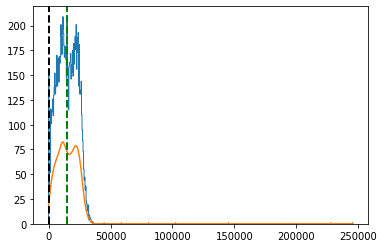

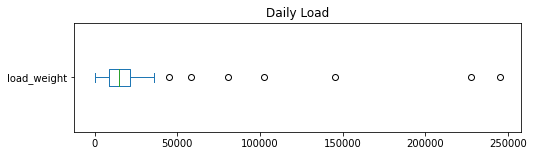

Average:  15173.665095377995
Median:  14920.0
Mode:  20.0
Skewness:  3.6992825886419376
Kurtosis:  88.34777993378147


In [24]:
mean      = np.mean(TDSL['load_weight'])
median    = np.median(TDSL['load_weight'])
mode      = stats.mode(TDSL['load_weight'])
skewness  = TDSL['load_weight'].skew()
kurtosis  = TDSL['load_weight'].kurt()
density   = stats.gaussian_kde(TDSL['load_weight'])

n, x, _ = plt.hist(TDSL['load_weight'], histtype='step', bins=600)  
plt.plot(x, density(x)*5**9)
plt.axvline(mean,   color='magenta', linestyle='dashed', linewidth=2, label = 'Average')
plt.axvline(median, color='green',   linestyle='dashed', linewidth=2, label = 'Median')
plt.axvline(mode[0][0],   color='black',   linestyle='dashed', linewidth=2, label = 'Mode')
plt.show()

TDSL['load_weight'].plot(kind='box', title='Daily Load', vert = 0, figsize=(8,2))
plt.show()

print('Average: ',  mean)
print('Median: ',   median)
print('Mode: ',     mode[0][0])
print('Skewness: ', skewness)
print('Kurtosis: ', kurtosis)

Deducing from these graph, the data is highly skewed to the right because the skewness value is at 3.6, higher than threshold of 1.0 to be considered skewed. The skewness is caused by some unusually high loads that skews the average to the right/higher. These high loads are considered as outliers by the system.

The outliers compose only 0.06% of the data, so let's eliminate these outliers from the data to see the proper load distribution throughout the year. 

##**E.2. Outlier elimination**

The outliers sit well beyind the distribution graph. We are going to use Z-value elimination method to eliminate them and them only.

In [25]:
TDSL['z-value'] = stats.zscore(TDSL.load_weight)

In [26]:
TDSL_trim = TDSL.copy()
TDSL_trim.drop(TDSL_trim[TDSL_trim['z-value'] < -3].index, inplace = True)
TDSL_trim.drop(TDSL_trim[TDSL_trim['z-value'] > 3].index, inplace = True)

In [27]:
TDSL_trim.shape

(10681, 6)

We have successfully dropped the seven outliers.

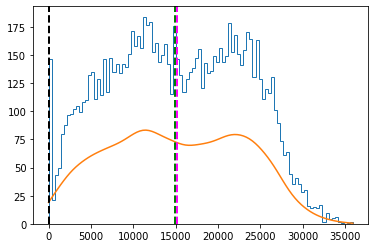

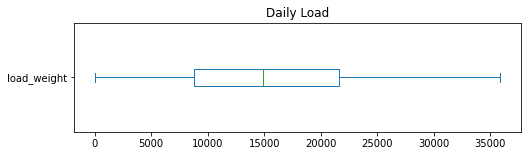

Average:  15098.838642393035
Median:  14920.0
Mode:  20.0
Skewness:  0.018714365900324756
Kurtosis:  -0.9735085850718455


In [28]:
mean      = np.mean(TDSL_trim['load_weight'])
median    = np.median(TDSL_trim['load_weight'])
mode      = stats.mode(TDSL_trim['load_weight'])
skewness  = TDSL_trim['load_weight'].skew()
kurtosis  = TDSL_trim['load_weight'].kurt()
density   = stats.gaussian_kde(TDSL_trim['load_weight'])

n, x, _ = plt.hist(TDSL_trim['load_weight'], histtype='step', bins=100)  
plt.plot(x, density(x)*5**9)
plt.axvline(mean,   color='magenta', linestyle='dashed', linewidth=2, label = 'Average')
plt.axvline(median, color='green',   linestyle='dashed', linewidth=2, label = 'Median')
plt.axvline(mode[0][0],   color='black',   linestyle='dashed', linewidth=2, label = 'Mode')
plt.show()

TDSL_trim['load_weight'].plot(kind='box', title='Daily Load', vert = 0, figsize=(8,2))
plt.show()

print('Average: ',  mean)
print('Median: ',   median)
print('Mode: ',     mode[0][0])
print('Skewness: ', skewness)
print('Kurtosis: ', kurtosis)

After dropping the outlier rows, the skewness value decreased to 0.01, well below the threshold of 0.5, so the distribution is considered to be unskewed. Compared to central tendencies of untrimmed data, the average matches closer to median. 

This data more accurately reflects the usual load intake of TDS Landfill. at slightly above 15 thousand lbs per load on average

##**E.3. Spread of data**

After examining TDSL's central tendencies, we can proceed to examine spread of the data

In [29]:
range    = TDSL_trim['load_weight'].max() - TDSL_trim['load_weight'].min()
variance = np.var(TDSL_trim['load_weight'])
std      = np.std(TDSL_trim['load_weight'])

Z1L = median - std
Z1U = median + std
Z2L = median - (2*std)
Z2U = median + (2*std)

print('Range: ',  range)
print('Variance: ',   variance)
print('Standard Deviation: ',     std)
print('Z1 ranges from ', Z1L, ' to ', Z1U)
print('Z2 ranges from ', Z2L, ' to ', Z2U)

Range:  35899.8836
Variance:  61636740.34540055
Standard Deviation:  7850.906975974212
Z1 ranges from  7069.093024025788  to  22770.906975974212
Z2 ranges from  -781.8139519484248  to  30621.813951948425


Using the obtained standard deviation and the standard deviation formula, we can deduce that:

*   Around 68.26% of load intake weight between 7069 and 22770 lbs
*   Around 95.45% of load intake weight less than 30621 lbs



#**F. New Site Study**

##**F.1 Estimating new site's capacity**

The city of Austin is planning to increase the city's disposal capacity by establishing a new disposal site. The site suitable for this objective would be a general type site like TDSL. From that conjencture, let's draw a parallel from TDSL using the confidence interval to estimate the capacity needed for the new site.

In [30]:
daily_load = TDSL_trim.groupby("report_date")['load_weight'].sum()

mean_dl = np.mean(daily_load)
std_dl  = np.std(daily_load)

In [31]:
mean_dl

1001681.3387540374

In [32]:
ci = stats.norm.interval(0.95, mean_dl, std_dl)

In [33]:
print('Capacity needed', ci[1], 'lbs')

Capacity needed 2008144.4606803523 lbs


Based from the calculation, if the new site needs to be around the same capacity to TDSL, it needs to be able to process around 2 million lbs of waste every day. At that capacity, the new site is expected to be able to handle daily load intake 95% of the time, which means for every 100 operating days, there would be 5 days where it needs to be diverted into other sites.

##**F.2. Hypothesizing new site's performane**

Let's say that the new site is only partially operating, and only process 750000 lbs of waste on average every day. Does that means on average TDSL still process significantly more waste?

We can use the hypothesis testing to answer this question.

Hypothesis 0: New Site μ >= TDSL μ

Hypothesis 1: New Site μ < TDSL μ

With those hypotheses, we are going to use single sample hypotest to find out the answer.

In [55]:
t_stat,p_val = stats.ttest_1samp(daily_load, 750000)
print('P-value:',p_val/2)
print('t-statistics:',t_stat)

P-value: 2.3136408960798014e-09
t-statistics: 6.199565193604155


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


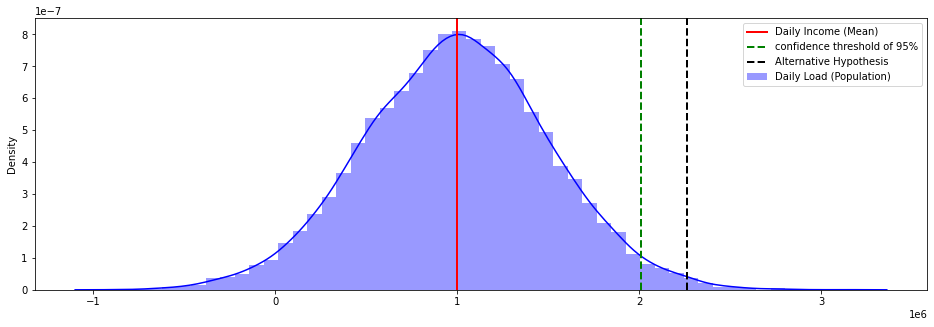

In [54]:
daily_load_pop = np.random.normal(mean_dl, std_dl, 10000)

mean_pop = np.mean(daily_load_pop)
std_pop  = np.std(daily_load_pop)

plt.figure(figsize=(16,5))
sns.distplot(daily_load_pop, label='Daily Load (Population)', color='blue')
plt.axvline(mean_dl, color='red', linewidth=2, label='Daily Income (Mean)')
plt.axvline(ci[1], color='green', linestyle='dashed', linewidth=2, label='confidence threshold of 95%')
plt.axvline(mean_pop + t_stat*std_pop, color='black', linestyle='dashed', linewidth=2, label = 'Alternative Hypothesis')
plt.legend()

Since P-value is lower than 0.05 we can reject Hypothesis 0. In other words, TDSL is still processing significantly more waste than the new site.

#**G. Predicting Waste Load**

Using mathematics, we can calculate the rate of change of daily waste disposal, and by an extent, forecast future waste disposal amount. 

That mathematics principle is called derivative, and we're going to calculate it with the computer using graphical method. Graphical method is more accurate than numerical method since every derivative value calculation is independent from the previous derivative value.

In [ ]:
Austin_daily_load = df.groupby("report_date")['load_weight'].sum()

days = Austin_daily_load.reset_index().index

ROC = np.diff(Austin_daily_load) / np.diff(days)

In [ ]:
Austin_daily_load

report_date
2021-01-02    2170130.0
2021-01-04    2920260.0
2021-01-05    2388540.0
2021-01-06    2396550.0
2021-01-07    2438330.0
                ...    
2021-07-05    1897290.0
2021-07-06    1921640.0
2021-07-07    1553080.0
2021-07-08    1417650.0
2021-07-09     120340.0
Name: load_weight, Length: 165, dtype: float64

In [ ]:
ROC[-1]*1

-1297310.0

ROC is an array that shows the rate of change of daily waste disposal. If it's value on a given day is 0, then that day's amount of waste disposed is the same as yesterday. If it is negative, then today's amount is less than yesterday, and vice versa.

Now, let's use the ROC of the last day and apply it to the last day's amount to predict tomorrow's waste disposal.

In [ ]:
tomorrow = Austin_daily_load[-1] + (ROC[-1]*1)

ROC only contains the ***rate of change*** by day! so if we want to calculate the actual change, we have to multiply it by the time period during the change. but since our time period is also a single day, we only have to put one as the multiplier.

In [ ]:
print('The predicted waste load for tomorrow (10th june 2022) is: ', tomorrow, 'lbs')

The predicted waste load for tomorrow (10th june 2022) is:  -1176970.0 lbs


Well, that does not look right. Let's check out the few last data to see if anything goes wrong with either the load amount or the ROC.

In [ ]:
Austin_daily_load[-4:]

report_date
2021-07-06    1921640.0
2021-07-07    1553080.0
2021-07-08    1417650.0
2021-07-09     120340.0
Name: load_weight, dtype: float64

It appears that the data on 9th June 2022 drops very low from the previous days, most likely because the day hasn't ended yet when the data was uploaded. The rate of change from 8th to 9th is crashing down suddenly and if we use that rate to extrapolate the 10th, of course we will get negative numbers. 

We can do the next best thing and extrapolate the 10th from the values of 7th and 8th and their ROC instead.

In [ ]:
tomorrow_2 = Austin_daily_load[-2] + (ROC[-2]*1)
print('The predicted waste load for tomorrow (10th june 2022) is: ', tomorrow_2, 'lbs')

The predicted waste load for tomorrow (10th june 2022) is:  1282220.0 lbs


Now that is the amount of waste we can reasonably expect for the next day.

#**Conclusions, Assumptions, Overall Analysis**

##**Conclusion**

* The city of Austin process around 1.5 million lbs of waste every day
* About two thirds of it is processed on TDSL alone, making it the vital waste disposal facility of the city.

##**Assumptions**

* The waste from city of Austin is rarely recycled. Probably due to high cost to profit margin of recycling process and lack of recyclability of American products. 

##**Analysis**

Final analysis from this assignment is that a developed and dense country like the Netherlands also have it's unique challenges and advantage in managing the COVID-19 pandemic.

The final analysis of this assignment is that the city of Austin still have a long way to go to minimize it's waste production.